<a href="https://colab.research.google.com/github/Amandine0610/project_sales_forecasting/blob/main/Summative_Intro_to_ml_%5BAmandineIrakoze%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2 ,l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# The Dataset
> ***Brief Description:***

***Problem Statement:*** Premium sporting goods lose 15–25% turnover due to inaccurate sales forecasting. The aim of the project is to predict if premium sports products will have high sales performance or not according to price, discount, marketing expenditure,
and seasonal factors.

***Dataset:*** Artificial premium sports sales with features like price, discount rate, marketing expenditure, seasonal factors, and binary target variable (high_sales: 1 for high sales, 0 for low sales).


In [16]:
try:
    df = pd.read_csv('Ecommerce_Sales_Prediction_Dataset.csv')
except FileNotFoundError:
    print("Error: 'Ecommerce_Sales_Prediction_Dataset.csv' not found.")
    raise

# Coerce numerical columns
numerical_cols = ['Price', 'Discount', 'Marketing_Spend', 'Units_Sold']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

# Create binary target
median_units_sold = df['Units_Sold'].median()
df['high_sales'] = (df['Units_Sold'] > median_units_sold).astype(int)

# Check class balance
print("\nClass Distribution (high_sales):")
print(df['high_sales'].value_counts(normalize=True))

# Encode categorical features
df = pd.get_dummies(df, columns=['Product_Category', 'Customer_Segment'], drop_first=True, dtype=int)

# Define features and target
feature_columns = [col for col in df.columns if col not in ['Date', 'Units_Sold', 'high_sales']]
X = df[feature_columns].values.astype(np.float32)
y = df['high_sales'].values.astype(np.int32)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

# Standardize numerical features
numerical_columns = ['Price', 'Discount', 'Marketing_Spend']
scaler = StandardScaler()
X_train_scaled = X_train.copy().astype(np.float32)
X_val_scaled = X_val.copy().astype(np.float32)
X_test_scaled = X_test.copy().astype(np.float32)
numerical_indices = [feature_columns.index(col) for col in numerical_columns]
for idx in numerical_indices:
    X_train_scaled[:, idx] = scaler.fit_transform(X_train[:, idx].reshape(-1, 1)).flatten()
    X_val_scaled[:, idx] = scaler.transform(X_val[:, idx].reshape(-1, 1)).flatten()
    X_test_scaled[:, idx] = scaler.transform(X_test[:, idx].reshape(-1, 1)).flatten()

# Save scaler
os.makedirs('saved_models', exist_ok=True)
dump(scaler, 'saved_models/scaler.joblib')

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("\nClass Weights:", class_weight_dict)

# Verify data shapes and dtypes
print("\nData Shapes and Dtypes:")
print(f"X_train_scaled: {X_train_scaled.shape}, {X_train_scaled.dtype}")
print(f"X_val_scaled: {X_val_scaled.shape}, {X_val_scaled.dtype}")
print(f"X_test_scaled: {X_test_scaled.shape}, {X_test_scaled.dtype}")
print(f"y_train: {y_train.shape}, {y_train.dtype}")
print(f"y_val: {y_val.shape}, {y_val.dtype}")
print(f"y_test: {y_test.shape}, {y_test.dtype}")


Class Distribution (high_sales):
high_sales
0    0.543
1    0.457
Name: proportion, dtype: float64

Class Weights: {np.int32(0): np.float64(0.9197368421052632), np.int32(1): np.float64(1.0956112852664577)}

Data Shapes and Dtypes:
X_train_scaled: (699, 9), float32
X_val_scaled: (151, 9), float32
X_test_scaled: (150, 9), float32
y_train: (699,), int32
y_val: (151,), int32
y_test: (150,), int32


#SECTION 1: Model Architecture:





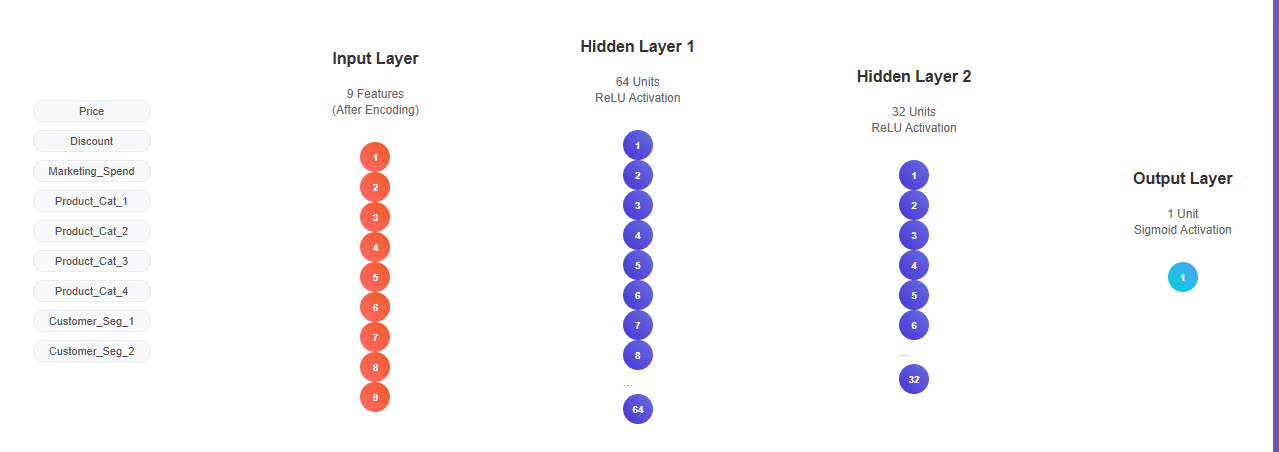

#Task: Define a function that creates models without and With specified Optimization techniques


In [17]:
def define_model(optimizer_name='adam', regularizer=None, early_stopping=False, dropout_rate=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                        validation_split=0.2, callbacks=callbacks, verbose=1)
    return model, history


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [18]:
def plot_loss_curves(history, title="Loss Curves"):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], 'b.', label='Training Loss')
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def compute_test_accuracy(model, X_test_scaled, y_test, threshold=0.5):
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred = (y_pred_proba > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Training Model 1: Baseline


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5501 - loss: 155.0970 - val_accuracy: 0.5857 - val_loss: 39.3804
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5169 - loss: 32.9815 - val_accuracy: 0.4214 - val_loss: 6.1949
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5223 - loss: 5.9525 - val_accuracy: 0.4143 - val_loss: 4.9382
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5037 - loss: 6.3339 - val_accuracy: 0.5786 - val_loss: 8.9646
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4555 - loss: 12.7221 - val_accuracy: 0.5857 - val_loss: 12.9506
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5361 - loss: 17.0850 - val_accuracy: 0.4143 - val_loss: 15.1606
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5154 - loss: 8.5698 - val_accuracy: 0.5214 - val_loss: 1.8331
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4741 - loss: 4.4901 - val_accuracy: 0.5857 - 

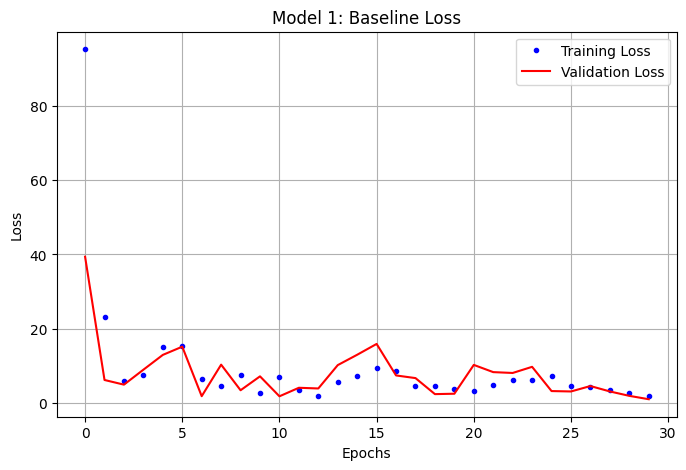

Test Accuracy: 0.4333


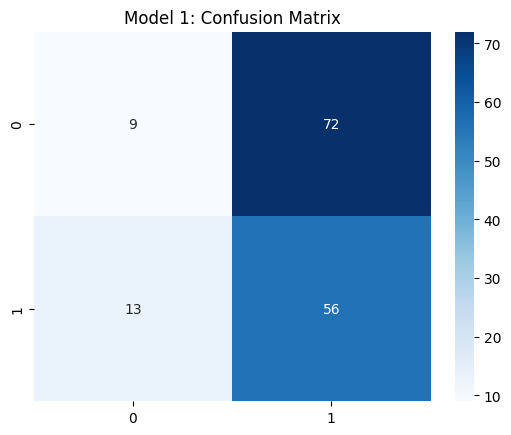


Training Model 2: Adam + L2 + Dropout + Early Stopping
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5000 - loss: 368.0488 - val_accuracy: 0.5571 - val_loss: 73.4772
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4911 - loss: 249.1071 - val_accuracy: 0.5571 - val_loss: 27.6887
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4760 - loss: 188.6717 - val_accuracy: 0.4786 - val_loss: 11.3745
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5189 - loss: 131.2657 - val_accuracy: 0.5571 - val_loss: 27.6008
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4762 - loss: 116.0169 - val_accuracy: 0.5571 - val_loss: 13.9690
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4574 - loss: 96.2310 - val_accuracy: 0.5429 - val_loss: 3.6348
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5192 - loss: 62.8163 - val_accuracy: 0.5571 - val_loss: 3.8144
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5271 - loss: 56.4538 - val_accuracy: 0.4

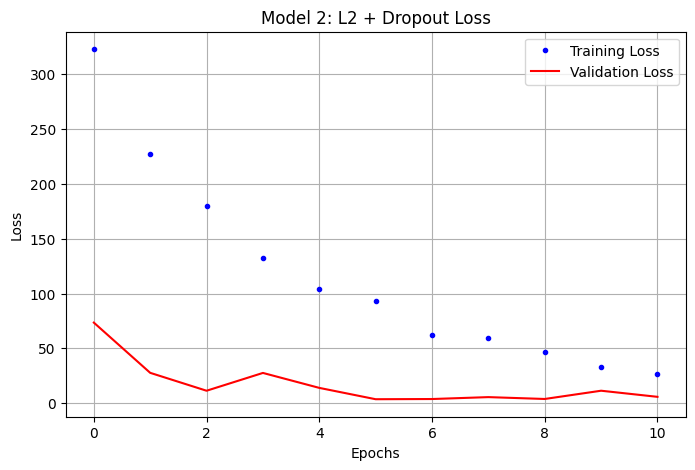

Test Accuracy: 0.4933


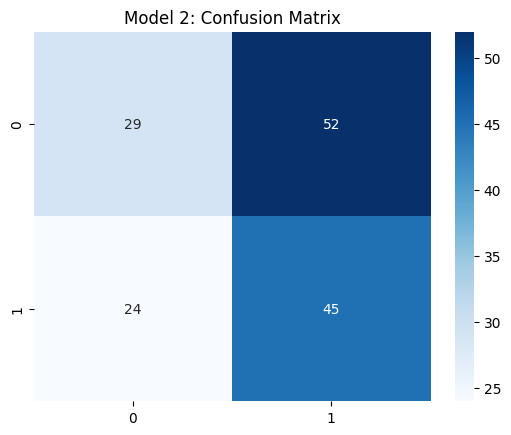


Training Model 3: RMSprop + L1 + Dropout
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4839 - loss: 373.3955 - val_accuracy: 0.4143 - val_loss: 104.9834
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5196 - loss: 246.5667 - val_accuracy: 0.5143 - val_loss: 5.8995
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5098 - loss: 187.2854 - val_accuracy: 0.5714 - val_loss: 9.3347
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5334 - loss: 127.5793 - val_accuracy: 0.4143 - val_loss: 49.0417
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5145 - loss: 99.8210 - val_accuracy: 0.5786 - val_loss: 33.7667
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5077 - loss: 84.5634 - val_accuracy: 0.5714 - val_loss: 18.1864
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4357 - loss: 84.3424 - val_accuracy: 0.4071 - val_loss: 23.6103
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4849 - loss: 56.7099 - val_accuracy: 0.4714 

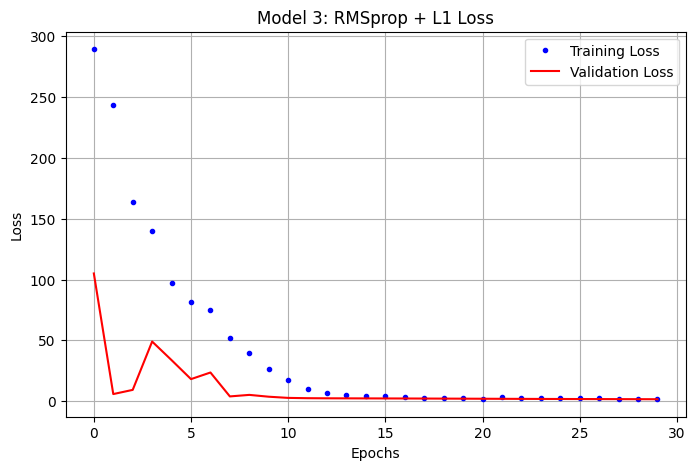

Test Accuracy: 0.5400


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


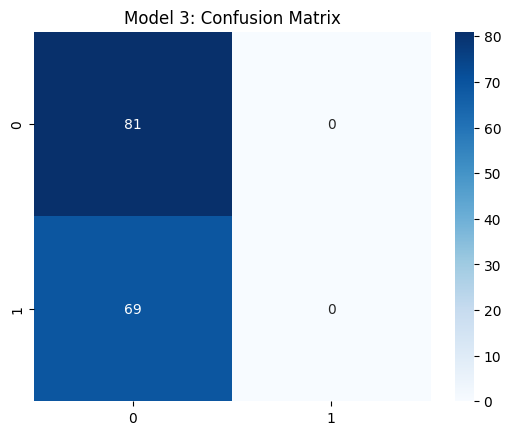


Training Model 4: Adam + L1/L2 + Early Stopping


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5382 - loss: 28.0662 - val_accuracy: 0.5071 - val_loss: 11.8614
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4601 - loss: 12.9308 - val_accuracy: 0.5857 - val_loss: 5.7891
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5674 - loss: 4.0373 - val_accuracy: 0.5357 - val_loss: 3.9524
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4670 - loss: 6.8456 - val_accuracy: 0.5857 - val_loss: 4.8169
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5020 - loss: 5.5938 - val_accuracy: 0.5643 - val_loss: 3.4195
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5145 - loss: 4.1254 - val_accuracy: 0.4143 - val_loss: 7.7958
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4965 - loss: 8.0121 - val_accuracy: 0.5643 - val_loss: 2.0180
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4998 - loss: 3.5802 - val_accuracy: 0.5929 - val

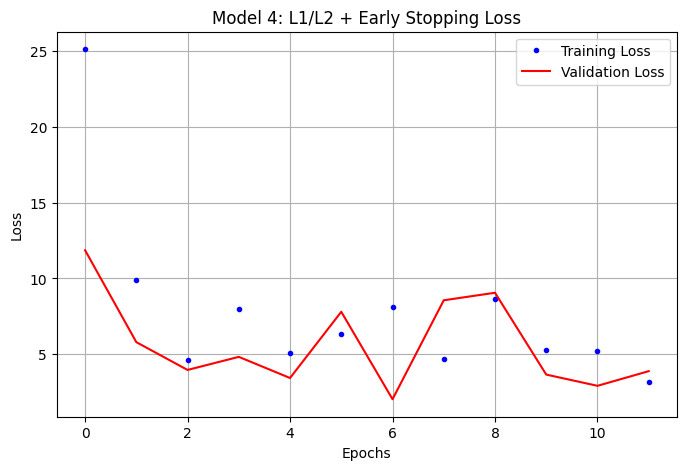

Test Accuracy: 0.5200


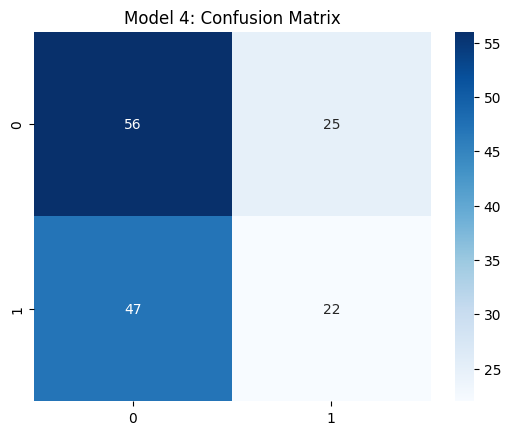


Optimization Results Table:
                    Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
0                Baseline    0.4333     0.4375  0.8116    0.5685   0.4707
1            L2 + Dropout    0.4933     0.4639  0.6522    0.5422   0.4389
2            RMSprop + L1    0.5400     0.0000  0.0000    0.0000   0.4784
3  L1/L2 + Early Stopping    0.5200     0.4681  0.3188    0.3793   0.5233


In [20]:
results = []

# Model 1: Baseline
print("Training Model 1: Baseline")
model1, history1 = define_model()
plot_loss_curves(history1, "Model 1: Baseline Loss")
acc1 = compute_test_accuracy(model1, X_test_scaled, y_test)
y_pred1 = (model1.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba1 = model1.predict(X_test_scaled, verbose=0)
metrics1 = {
    'Model': 'Baseline',
    'Accuracy': acc1,
    'Precision': precision_score(y_test, y_pred1),
    'Recall': recall_score(y_test, y_pred1),
    'F1-Score': f1_score(y_test, y_pred1),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba1)
}
results.append(metrics1)
cm1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title("Model 1: Confusion Matrix")
plt.show()

# Model 2: Adam + L2 + Dropout + Early Stopping
print("\nTraining Model 2: Adam + L2 + Dropout + Early Stopping")
model2, history2 = define_model(
    regularizer=l2(0.01), dropout_rate=0.3, early_stopping=True
)
plot_loss_curves(history2, "Model 2: L2 + Dropout Loss")
acc2 = compute_test_accuracy(model2, X_test_scaled, y_test)
y_pred2 = (model2.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba2 = model2.predict(X_test_scaled, verbose=0)
metrics2 = {
    'Model': 'L2 + Dropout',
    'Accuracy': acc2,
    'Precision': precision_score(y_test, y_pred2),
    'Recall': recall_score(y_test, y_pred2),
    'F1-Score': f1_score(y_test, y_pred2),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba2)
}
results.append(metrics2)
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title("Model 2: Confusion Matrix")
plt.show()

# Model 3: RMSprop + L1 + Dropout
print("\nTraining Model 3: RMSprop + L1 + Dropout")
model3, history3 = define_model(
    optimizer_name='rmsprop', regularizer=l1(0.01), dropout_rate=0.3
)
plot_loss_curves(history3, "Model 3: RMSprop + L1 Loss")
acc3 = compute_test_accuracy(model3, X_test_scaled, y_test)
y_pred3 = (model3.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba3 = model3.predict(X_test_scaled, verbose=0)
metrics3 = {
    'Model': 'RMSprop + L1',
    'Accuracy': acc3,
    'Precision': precision_score(y_test, y_pred3),
    'Recall': recall_score(y_test, y_pred3),
    'F1-Score': f1_score(y_test, y_pred3),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba3)
}
results.append(metrics3)
cm3 = confusion_matrix(y_test, y_pred3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title("Model 3: Confusion Matrix")
plt.show()

# Model 4: Adam + L1/L2 + Early Stopping
print("\nTraining Model 4: Adam + L1/L2 + Early Stopping")
model4, history4 = define_model(
    regularizer=l1_l2(l1=0.005, l2=0.005), early_stopping=True
)
plot_loss_curves(history4, "Model 4: L1/L2 + Early Stopping Loss")
acc4 = compute_test_accuracy(model4, X_test_scaled, y_test)
y_pred4 = (model4.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba4 = model4.predict(X_test_scaled, verbose=0)
metrics4 = {
    'Model': 'L1/L2 + Early Stopping',
    'Accuracy': acc4,
    'Precision': precision_score(y_test, y_pred4),
    'Recall': recall_score(y_test, y_pred4),
    'F1-Score': f1_score(y_test, y_pred4),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba4)
}
results.append(metrics4)
cm4 = confusion_matrix(y_test, y_pred4)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues')
plt.title("Model 4: Confusion Matrix")
plt.show()


results_df = pd.DataFrame(results)
print("\nOptimization Results Table:")
print(results_df.round(4))


results_df.to_csv('optimization_results.csv', index=False)

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [21]:
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest Model: {best_model_name} (F1-Score: {results_df.loc[best_model_idx, 'F1-Score']:.4f})")
best_model = [model1, model2, model3, model4][best_model_idx]
y_pred_best = (best_model.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
print("\nSample Predictions (First 5):")
for i in range(5):
    print(f"Sample {i+1}: Features={X_test[i]}, Predicted={'High' if y_pred_best[i] else 'Low'}, True={'High' if y_test[i] else 'Low'}")


Best Model: Baseline (F1-Score: 0.5685)

Sample Predictions (First 5):
Sample 1: Features=[757.72  18.   898.09   0.     1.     0.     0.     1.     0.  ], Predicted=High, True=Low
Sample 2: Features=[1.00670e+02 3.28500e+01 7.71754e+03 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00], Predicted=High, True=High
Sample 3: Features=[5.01800e+02 2.24700e+01 7.05086e+03 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00], Predicted=High, True=Low
Sample 4: Features=[6.37140e+02 3.21200e+01 8.61197e+03 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00], Predicted=High, True=High
Sample 5: Features=[8.17670e+02 7.04000e+00 3.06943e+03 1.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00], Predicted=High, True=Low


Congratulations!!
